In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,sys,itertools,math,datetime,time

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import networkx as nx

In [191]:
class GRAPH():
    def __init__(
            self,
            W,
            b,
            in_nodes=[0,1],
            out_nodes=[2],
            actfun=lambda x: max(0,x),
            enfun=np.linalg.norm,
            randomize=[0,0],
            allow_self_recurrence=False,
            enforced_sparsity_bounds=[0,1],
            eps=0.0001,
            maxsteps=10000 
        ):
        self.W = W
        self.b = b
        self.in_nodes = in_nodes
        self.out_nodes = out_nodes
        self.sparsity = np.where(self.W==0)[0].shape[0]/(self.W.shape[0]**2)
        self.allow_self_recurrence = allow_self_recurrence
        self.enforced_sparsity_bounds = enforced_sparsity_bounds
        self.n_nodes = b.shape[0]
        self.actfun = actfun
        self.enfun = enfun
        self.s = rnd.randn(self.n_nodes)
        self.S = [self.s]
        self.E = [self.enfun(self.s)]
        self.D = [np.nan]
        self.randomize = randomize
        self.eps = eps
        self.maxsteps = maxsteps
        # Settings validations and return
        self.self_validate()
        return
    def force_states(self,s):
        self.s = s
        return
    def step(self,n=1,out=False):
        nn = 0
        while nn<n:
            states = np.einsum('ij,j->i',self.W,self.s) + self.b
            states += self.randomize[1]*rnd.randn(self.n_nodes) + self.randomize[0]
            self.s = np.array([self.actfun(states[k]) for k in range(states.shape[0])])
            self.S.append(self.s)
            self.E.append(self.enfun(self.s))
            self.D.append(self.enfun(self.S[-1]-self.S[-2]))
            nn += 1
        if out:
            return self.s
        else:
            return
    def apply(self,x):
        x = np.array(x)
        assert x.shape[0]==len(self.in_nodes),'Input shape does not match configuration'
        self.s[self.in_nodes] = x
        settled = self.settle()
        if not settled:
            y = np.nan
        else:
            y = self.s[self.out_nodes]
        return y
    def settle(self):
        self.step(1)
        ctr = 0
        while self.D[-1]>self.eps and ctr<self.maxsteps: 
            self.step(1)
            ctr += 1
        settled = True
        if ctr>=self.maxsteps: 
            settled = False
            print('Could not settle in {0} steps, caught in loop.'.format(self.maxsteps))
        return settled
    def self_validate(self):
        # Weights and biases shapes must match
        assert W.shape[0]==W.shape[1] and b.shape[0]==W.shape[0] and len(W.shape)==2 and len(b.shape)==1,'Setup dimensions do not match'
        # If the graph should be non-selfrecurrent, test that
        if not self.allow_self_recurrence:
            assert sum([abs(W[i,i]) for i in range(W.shape[0])])==0,'Graph is self-recurrent when graph specifications state non-self-recurrent graph'
        # Test sparsity
        assert self.enforced_sparsity_bounds[0]<self.sparsity and self.enforced_sparsity_bounds[1]>self.sparsity,'Sparsity bounds violated: Sparsity = {0}'.format(self.sparsity)
        # Validate in and out nodes in weight matrix
        assert self.W[self.in_nodes,:].sum()==0 and self.W[:,self.out_nodes].sum()==0 and self.b[self.in_nodes].sum()==0 and self.b[self.out_nodes].sum()==0,'Input/Output nodes incorrectly connected' 
        # Done with the tests
        return

In [209]:
Ns = 100

# Interaction nodes
in0 = [0,1]
out0 = [-1]

# Weights
W = rnd.randn(Ns,Ns)
# Assert non-selfrecurrence
for k in range(W.shape[0]): W[k,k] = 0
# Set input and output nodes
W[in0,:] = 0
W[:,out0] = 0

# Biases
b = np.zeros(Ns).reshape(-1)

G = GRAPH(
    W,
    b,
    in_nodes=in0,
    out_nodes=out0,
    #actfun=lambda x: 1/(1+np.exp(-x)),
    randomize=[0,0]
)

In [210]:
G.apply([5,10])

array([0])

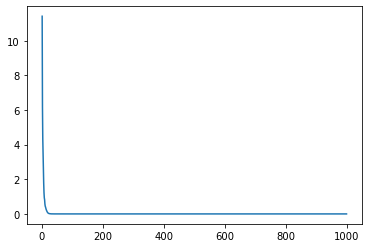

In [141]:
plt.plot((G.D))

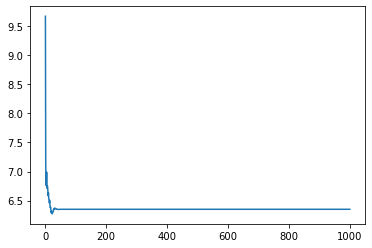

In [133]:
plt.plot(G.E)